In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 15.9 MB/s eta 0:00:00


In [2]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [3]:
import os
import glob
import shutil
import random
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from ultralytics import YOLO
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    Rotate, HueSaturationValue, RGBShift
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
augmentation = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
    Rotate(limit=15, p=0.5),
    HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.5),
    RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5)
], bbox_params={'format': 'yolo', 'label_fields': ['class_labels']})

In [5]:
INPUT_DIR = '/kaggle/input/inmemaske-1-1/inmemaske'
DATASET_DIR = '/kaggle/working/dataset'

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(DATASET_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(DATASET_DIR, split, 'labels'), exist_ok=True)

In [6]:
def process_pair(pair, split, apply_augmentation=False):
    maskeli_path, maskesiz_path = pair
    base_name = os.path.basename(maskeli_path)
    
    # Görüntüleri yükle
    maskeli = cv2.imread(maskeli_path)
    maskesiz = cv2.imread(maskesiz_path)
    
    if maskeli is None or maskesiz is None:
        print(f"Hata! Görüntü okunamadı: {maskeli_path}")
        return

    # Fark maskesi oluştur
    diff = cv2.absdiff(maskeli, maskesiz)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY_INV, 11, 2)
    
    # Kontur işlemleri
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    valid_boxes = []
    
    for cnt in contours:
        if cv2.contourArea(cnt) < 100:
            continue
            
        x,y,w,h = cv2.boundingRect(cnt)
        x_center = (x + w/2) / 512
        y_center = (y + h/2) / 512
        width = w / 512
        height = h / 512
        
        if (x_center + width/2) > 1.0 or (y_center + height/2) > 1.0:
            continue
            
        valid_boxes.append([x_center, y_center, width, height])

    if not valid_boxes:
        return
    
    # Sadece eğitim verilerine augmentasyon uygula
    if apply_augmentation:
        augmented = augmentation(
            image=maskesiz,
            bboxes=valid_boxes,
            class_labels=[0]*len(valid_boxes)
        )
        image = augmented['image']
        bboxes = augmented['bboxes']
    else:
        image = maskesiz
        bboxes = valid_boxes
    
    # Görüntüyü ve etiketleri kaydet
    cv2.imwrite(f'{DATASET_DIR}/{split}/images/{base_name}', image)
    with open(f'{DATASET_DIR}/{split}/labels/{base_name.replace(".png", ".txt")}', 'w') as f:
        for bbox in bboxes:
            f.write(f"0 {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")


In [7]:
def create_yolo_dataset():
    # Veri yollarını topla
    maskeli_images = glob.glob(f'{INPUT_DIR}/maskeli/**/*.png', recursive=True)
    image_pairs = []
    
    # Eşleştirme yap
    for maskeli_path in maskeli_images:
        category = 'iskemik' if 'iskemik' in maskeli_path else 'kanamali'
        base_name = os.path.basename(maskeli_path)
        maskesiz_path = f"{INPUT_DIR}/maskesiz/{category}/{base_name}"
        
        if os.path.exists(maskesiz_path):
            image_pairs.append((maskeli_path, maskesiz_path))
    
    # Veriyi böl
    random.shuffle(image_pairs)
    train_size = int(0.7 * len(image_pairs))
    val_size = int(0.15 * len(image_pairs))
    
    train_pairs = image_pairs[:train_size]
    val_pairs = image_pairs[train_size:train_size+val_size]
    test_pairs = image_pairs[train_size+val_size:]
    
    # Veriyi işle
    for pair in train_pairs:
        process_pair(pair, 'train', apply_augmentation=True)
        
    for pair in val_pairs:
        process_pair(pair, 'val')
        
    for pair in test_pairs:
        process_pair(pair, 'test')
    
    print(f"Oluşturulan veri: Train={len(train_pairs)}, Val={len(val_pairs)}, Test={len(test_pairs)}")

create_yolo_dataset()


Oluşturulan veri: Train=1556, Val=333, Test=334


In [8]:
yaml_content = f"""
path: {DATASET_DIR}
train: train/images
val: val/images
test: test/images

names:
  0: stroke
"""

with open(f'{DATASET_DIR}/dataset.yaml', 'w') as f:
    f.write(yaml_content)

In [9]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 2


In [10]:
model = YOLO('yolov8m.pt')

results = model.train(
    data=f'{DATASET_DIR}/dataset.yaml',
    epochs=50,
    imgsz=512,
    batch=16,
    patience=30,
    optimizer='SGD',
    momentum=0.93,
    weight_decay=0.0005,
    lr0=0.001,
    lrf=0.01,
    warmup_epochs=3,
    warmup_momentum=0.8,
    hsv_h=0.3,
    hsv_s=0.7,
    hsv_v=0.4,
    flipud=0.5,
    mosaic=1.0,
    box=0.05,
    cls=0.5
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 224MB/s]


Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/dataset/dataset.yaml, epochs=50, time=None, patience=30, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 16.8MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 70.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/train/labels... 1553 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1553/1553 [00:02<00:00, 535.50it/s]

train: New cache created: /kaggle/working/dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/dataset/val/labels... 332 images, 0 backgrounds, 0 corrupt: 100%|██████████| 332/332 [00:00<00:00, 602.60it/s]

val: New cache created: /kaggle/working/dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.93) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G    0.01628      3.597      2.165          3        512: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]


                   all        332        471      0.287       0.17      0.158     0.0694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G    0.01365       2.43      1.915          0        512: 100%|██████████| 98/98 [00:30<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.48it/s]

                   all        332        471      0.476      0.297       0.32      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G    0.01198      1.855      1.696          1        512: 100%|██████████| 98/98 [00:30<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.46it/s]

                   all        332        471      0.535      0.439      0.459      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G    0.01168      1.699       1.65          1        512: 100%|██████████| 98/98 [00:31<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.45it/s]

                   all        332        471      0.625      0.488      0.527      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G     0.0113      1.525      1.572          2        512: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.44it/s]

                   all        332        471      0.796      0.444      0.561       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G     0.0111      1.446      1.526          4        512: 100%|██████████| 98/98 [00:31<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]

                   all        332        471        0.7      0.522      0.597      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G    0.01099      1.391      1.507          4        512: 100%|██████████| 98/98 [00:31<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.40it/s]

                   all        332        471       0.72      0.582      0.638      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G    0.01087      1.373      1.493          1        512: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]

                   all        332        471      0.717      0.529      0.604      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G    0.01047      1.324      1.459          1        512: 100%|██████████| 98/98 [00:31<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471      0.762      0.556       0.67      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G    0.01038       1.25      1.455          2        512: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

                   all        332        471      0.813      0.571      0.661      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G    0.01044      1.203      1.443          2        512: 100%|██████████| 98/98 [00:31<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471      0.831      0.563      0.696      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G    0.01044      1.219      1.437          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

                   all        332        471      0.778      0.566      0.678      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G     0.0102       1.24      1.442          3        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]

                   all        332        471      0.788      0.597      0.687      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G    0.01026      1.158      1.427          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.33it/s]

                   all        332        471      0.828      0.564      0.697      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G    0.01025      1.163      1.422          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]

                   all        332        471      0.784      0.586      0.677      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G    0.01004      1.154      1.406          4        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]

                   all        332        471      0.778      0.599      0.688      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G   0.009944       1.14      1.407          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]

                   all        332        471      0.835      0.584      0.697      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G   0.009889      1.121      1.402          6        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]

                   all        332        471      0.811      0.609      0.713      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G   0.009794      1.092      1.374          4        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

                   all        332        471      0.806      0.601      0.709      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G   0.009785      1.086      1.395          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]

                   all        332        471      0.807      0.601      0.708      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G    0.00976      1.067      1.399          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471      0.782      0.601      0.701      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G   0.009739      1.067      1.366          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.31it/s]

                   all        332        471       0.84        0.6      0.718      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G    0.00959       1.04       1.37          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.31it/s]

                   all        332        471      0.843      0.601      0.723      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G   0.009507      1.013      1.347          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471      0.818      0.639      0.736       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G    0.00953      0.998      1.353          5        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

                   all        332        471        0.8      0.627      0.724      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G   0.009523      1.004      1.345          5        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471      0.806      0.641      0.735      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G   0.009408     0.9994      1.359          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

                   all        332        471       0.78      0.656      0.741      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G   0.009405      0.992      1.342          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]

                   all        332        471      0.778      0.631      0.707      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G   0.009468      0.991      1.353          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471       0.81      0.628      0.737      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G   0.009279     0.9718      1.342          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.32it/s]

                   all        332        471      0.806      0.643      0.741      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G   0.009243     0.9468      1.333          5        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471      0.797      0.632      0.741      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G   0.009197     0.9107      1.317          4        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471        0.8      0.643      0.732      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G   0.009295     0.9163      1.325          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.34it/s]

                   all        332        471      0.837      0.631      0.749      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G   0.009144     0.9175      1.314          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]

                   all        332        471      0.796      0.641      0.747      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G   0.009066     0.9237      1.309          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]

                   all        332        471      0.786      0.645      0.747      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G   0.009323     0.9417      1.334          3        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471      0.794      0.654      0.756      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G   0.008785     0.8882      1.289          0        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471      0.795      0.659      0.754      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G   0.009034     0.9033      1.309          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.29it/s]

                   all        332        471      0.834      0.605       0.73       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G   0.009034     0.8878      1.311          3        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]

                   all        332        471      0.823      0.622      0.734      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G   0.008912     0.8752      1.289          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]

                   all        332        471      0.847      0.635      0.755      0.478


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G   0.008602     0.7832      1.311          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]

                   all        332        471      0.811      0.657      0.748      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G   0.008564     0.7436      1.297          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.38it/s]

                   all        332        471      0.815      0.633      0.732       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G   0.008453     0.7505        1.3          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.36it/s]

                   all        332        471      0.747      0.686      0.749      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G   0.008463     0.7288      1.296          3        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.35it/s]

                   all        332        471      0.827      0.669      0.748      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G   0.008367     0.7127       1.28          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.33it/s]

                   all        332        471      0.811      0.665       0.75      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G   0.008426      0.726      1.285         11        512: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.30it/s]

                   all        332        471      0.824      0.654      0.753      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G   0.008256     0.6972      1.276          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.39it/s]

                   all        332        471      0.797      0.667      0.755      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G   0.008234     0.6878      1.274          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

                   all        332        471      0.826      0.658      0.759      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G   0.008278     0.6983      1.279          1        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.40it/s]

                   all        332        471      0.861      0.648       0.76      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G   0.008218     0.6889      1.266          2        512: 100%|██████████| 98/98 [00:32<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  3.37it/s]

                   all        332        471      0.872      0.648       0.76      0.476



50 epochs completed in 0.500 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


                   all        332        471      0.848      0.635      0.755      0.478


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 6.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


In [11]:
metrics = model.val()
print(f"Model performansı: mAP50-95: {metrics.box.map}")

Ultralytics 8.3.91 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /kaggle/working/dataset/val/labels.cache... 332 images, 0 backgrounds, 0 corrupt: 100%|██████████| 332/332 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.32it/s]


                   all        332        471      0.849      0.635      0.755      0.477


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.7ms preprocess, 14.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train2
Model performansı: mAP50-95: 0.4768211870550946



image 1/1 /kaggle/working/dataset/test/images/12850.png: 512x512 (no detections), 25.4ms
Speed: 1.2ms preprocess, 25.4ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)


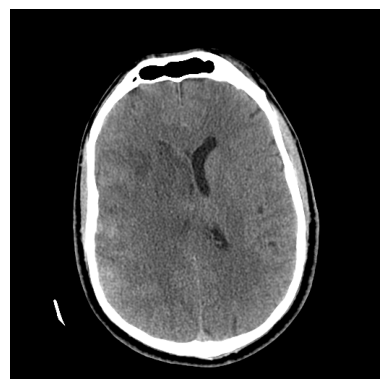


image 1/1 /kaggle/working/dataset/test/images/16496.png: 512x512 (no detections), 25.4ms
Speed: 1.0ms preprocess, 25.4ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)


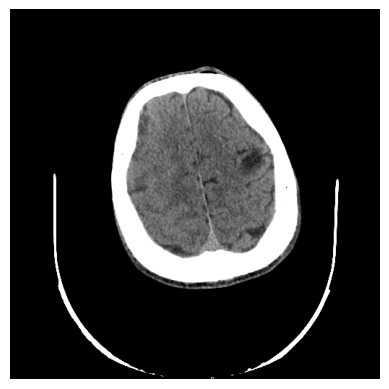


image 1/1 /kaggle/working/dataset/test/images/13183.png: 512x512 1 stroke, 25.4ms
Speed: 0.9ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 512)


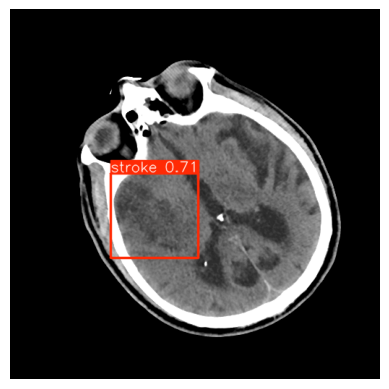

In [12]:
test_images = glob.glob(f'{DATASET_DIR}/test/images/*.png')[:3]

for img_path in test_images:
    results = model.predict(img_path, conf=0.5)
    plotted = results[0].plot()
    plt.imshow(plotted)
    plt.axis('off')
    plt.show()